In [10]:
import json
from functools import partial
from typing import List, Set
import os
import pickle
from collections import Counter
from itertools import combinations


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# from distutils.dir_util import copy_tree
# copy_tree("/kaggle/input/hackathon-files-for-participants-ozon", "/kaggle/working/hackathon_files_for_participants_ozon")

### Load data

In [3]:
dataset = pd.read_parquet("hackathon_files_for_participants_ozon/train_pairs.parquet")
etl = pd.read_parquet("hackathon_files_for_participants_ozon/train_data.parquet")

To apply transitivity rule, we can:

1. Iterate over rows of the dataset
2. If one of products is already in one of the sets, we should find a set that it belogs to and put the second products in the same set.


The operations that data structure should implement:
* insertion in the structure operation
* returning a list of all sets ofter merging sets with at least 1 common element
What structure should we use?
1. We can use a list of sets
    * insert():
        * find(id1: int) -> list_index: int - we should iterate over the whole list, checking each set, and return its index or -1
        * insertion_in_the_set
            * list_of_sets[list_index].insert(id2) if list_index != -1 else list_of_sets.append(set(id1, id2))
    * 
2. We can use id_to_sets: dict[int, Tuple[set, set]], that maps an id to it's set
    * insert(id1, id2, target):
        * if id1


But there may be labeling errors and one product may belong to several sets. If that happens those sets will merge and there will be a lot of errors :(

In [35]:
class ProductGroups_list:
    def __init__(self):
        self.same_products_l_of_s: List[Set[int]] = []
        self.different_products_l_of_s: List[Set[int]]  = []
    
    def insert(self, id1: int, id2: int, target: bool) -> None:
        list_of_sets = self.same_products_l_of_s if target else self.different_products_l_of_s
        
        i1 = self._find(id1, list_of_sets)
        i2 = self._find(id2, list_of_sets)
        if i1 != -1 and id2 != -1:
            list_of_sets[i1].update(list_of_sets[i2])
            del list_of_sets[i2]
        elif i1 == -1 and id2 == -1:
            list_of_sets.append({id1, id2})
        elif i1 == -1 and i2 != -1:
            list_of_sets[i1].add(id2)
        else: # i1 != -1 and i2 == -1
            list_of_sets[i2].add(id1)
        
    @staticmethod
    def _find(product_id: int, list_of_sets: List[Set[int]]) -> int:
        for i, s in enumerate(list_of_sets):
            if product_id in s:
                return i
        return -1
    
    def get_same_product_sets(self):
        return self.same_products_l_of_s
    
    def get_different_product_sets(self):
        return self.different_products_l_of_s

    
    
class ProductGroups_dict:
    def __init__(self):
        self.id_to_set_same: dict[int, Set[int]] = {}
        self.id_to_set_different: dict[int, Set[int]] = {}
    
    def insert(self, id1: int, id2: int, target: bool) -> None:
        id_to_set = self.id_to_set_same if target else self.id_to_set_different
        
        has_id1 = id1 in id_to_set
        has_id2 = id2 in id_to_set
        if has_id1 and has_id2:
            id_to_set[id1].update(id_to_set[id2])
            id_to_set[id2] = id_to_set[id1]
        elif has_id1 and not has_id2:
            id_to_set[id1].add(id2)
            id_to_set[id2] = id_to_set[id1]
        elif not has_id1 and has_id2:
            id_to_set[id2].add(id1)
            id_to_set[id1] = id_to_set[id2]
        else: # not has_id1 and not has_id2:
            id_to_set[id1] = id_to_set[id2] = {id1, id2}
    
    def get_same_product_sets(self):
        return set(frozenset(v) for v in self.id_to_set_same.values())
    
    def get_different_product_sets(self):
        return set(frozenset(v) for v in self.id_to_set_different.values())


class ProductGroups(ProductGroups_dict):
    pass

In [36]:
product_groups = ProductGroups()
for _, (target, id1, id2) in tqdm(dataset.iterrows(), total = len(dataset)):
    product_groups.insert(id1, id2, target)


same_prods_sets = product_groups.get_same_product_sets()
different_prods_sets = product_groups.get_different_product_sets()

100%|██████████| 306540/306540 [00:21<00:00, 14438.27it/s]


In [40]:
same_prods_sets_len_count = Counter([len(s) for s in same_prods_sets])
print(f"{same_prods_sets_len_count = }")


different_prods_sets_len_count = Counter([len(s) for s in different_prods_sets])
print(f"{different_prods_sets_len_count = }")

same_prods_sets_len_count = Counter({2: 78586, 3: 10367, 4: 2835, 5: 1162, 6: 576, 7: 340, 8: 186, 9: 132, 10: 92, 11: 76, 12: 59, 13: 51, 14: 38, 15: 28, 17: 23, 18: 18, 16: 17, 20: 14, 22: 9, 19: 9, 23: 8, 21: 8, 28: 8, 24: 8, 33: 7, 3737: 7, 31: 6, 43: 6, 3687: 6, 3640: 5, 3718: 5, 25: 5, 39: 5, 42: 5, 409: 5, 3736: 5, 3739: 5, 30: 5, 3757: 5, 26: 5, 52: 5, 3735: 5, 32: 5, 3751: 5, 3690: 4, 3709: 4, 41: 4, 3740: 4, 44: 4, 3619: 4, 27: 4, 3673: 4, 35: 4, 40: 4, 3712: 4, 3671: 3, 3719: 3, 101: 3, 3631: 3, 3717: 3, 3686: 3, 181: 3, 45: 3, 3749: 3, 89: 3, 3754: 3, 93: 3, 3654: 3, 415: 3, 46: 3, 482: 3, 263: 3, 37: 3, 29: 3, 3705: 3, 59: 3, 3626: 3, 38: 3, 182: 3, 3704: 3, 3524: 3, 3727: 3, 67: 3, 3650: 3, 121: 3, 3676: 3, 3759: 3, 55: 3, 406: 3, 61: 3, 3765: 3, 3684: 3, 290: 3, 3627: 3, 3716: 3, 49: 3, 3694: 3, 3753: 3, 47: 3, 453: 3, 393: 3, 90: 2, 3496: 2, 478: 2, 3710: 2, 3609: 2, 494: 2, 3629: 2, 404: 2, 3634: 2, 3746: 2, 326: 2, 34: 2, 3723: 2, 3658: 2, 69: 2, 113: 2, 480: 2, 3689:

In [ ]:
columns = ["target", "variantid1", "variantid2"]
rows = []

for target, prods_sets in zip([1, 0], [same_prods_sets, different_prods_sets]):
    for prods_set in tqdm(prods_sets):
        pairs = combinations(prods_set, 2)
        rows.extend([(target, *pair) for pair in pairs])

new_dataset = pd.DataFrame(rows, columns = columns)

Get raw data for each variantid.

In [14]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [15]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


Features functions.

In [16]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features


In [17]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [18]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

# btw try to add distances between main pic embs

In [19]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

In [21]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

Let's find good cat size threshold

In [27]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

10k for "rest" cats probably is good

In [29]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

Choose features

In [ ]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist"]

Split dataset

In [ ]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

Train model

In [39]:
models_path = "models"
if not os.path.exists(models_path):
   os.makedirs(models_path)

In [40]:
model = CatBoostClassifier()

model.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)
model.save_model(f"./models/baseline.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123728
0:	learn: 0.6772236	test: 0.6765419	best: 0.6765419 (0)	total: 100ms	remaining: 1m 40s


100:	learn: 0.5913786	test: 0.5878534	best: 0.5878534 (100)	total: 3.38s	remaining: 30.1s
200:	learn: 0.5819706	test: 0.5802067	best: 0.5802067 (200)	total: 6.81s	remaining: 27.1s
300:	learn: 0.5770583	test: 0.5773548	best: 0.5773548 (300)	total: 10.2s	remaining: 23.6s
400:	learn: 0.5730919	test: 0.5752859	best: 0.5752859 (400)	total: 13.5s	remaining: 20.2s
500:	learn: 0.5698770	test: 0.5743677	best: 0.5743662 (498)	total: 16.9s	remaining: 16.9s
600:	learn: 0.5670512	test: 0.5733509	best: 0.5733407 (597)	total: 20.7s	remaining: 13.8s
700:	learn: 0.5643675	test: 0.5726513	best: 0.5726513 (700)	total: 24.1s	remaining: 10.3s
800:	learn: 0.5618326	test: 0.5720850	best: 0.5720698 (796)	total: 27.5s	remaining: 6.83s
900:	learn: 0.5596079	test: 0.5714596	best: 0.5714596 (900)	total: 30.9s	remaining: 3.4s
999:	learn: 0.5575104	test: 0.5710985	best: 0.5710985 (999)	total: 34.2s	remaining: 0us

bestTest = 0.5710985126
bestIteration = 999



### Metric

In [41]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [42]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [43]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.3195509329014865

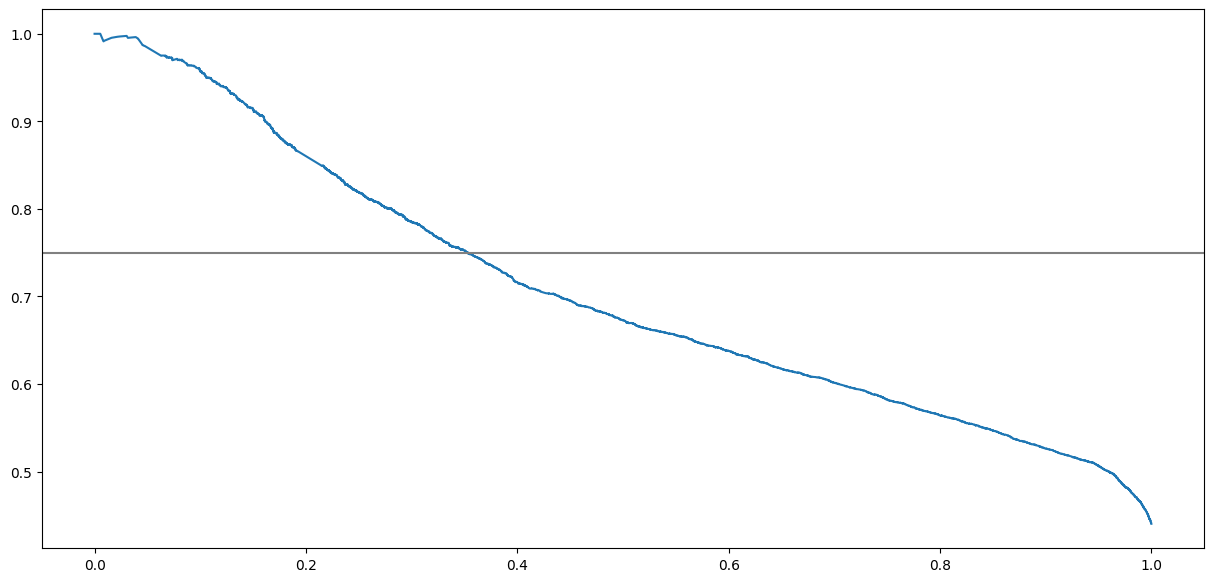

In [44]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

### Submission

In [ ]:
test_pairs = pd.read_parquet("hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet")
test_etl = pd.read_parquet("hackathon_files_for_participants_ozon/test_data.parquet")

Generate the same features as for train

In [ ]:
test_features = (
    test_pairs
    .merge(
        test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [ ]:
test_features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [ ]:
test_features["cat3"] = test_features["categories1"].apply(lambda x: json.loads(x)["3"])

In [ ]:
test_features.shape

In [ ]:
test_cat3_counts = test_features["cat3"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

In [ ]:
test_features["cat3_grouped"] = test_features["cat3"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")
# btw you can rename to `rest` the same categories that were assigned to this group in train

In [ ]:
submission_example = test_features.copy()

In [ ]:
submission_example["scores"] = model.predict_proba(test_features[feats])[:, 1]

In [ ]:
submission_example = submission_example[["variantid1", "variantid2", "scores"]]

In [ ]:
submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_example.csv", index=False)

Upload your submission to leaderboard :)

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.